<a href="https://colab.research.google.com/github/Angel-Castro-RC/NLP/blob/main/F3_4_SaulVarshavsky_SemanticFolding_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the Model:

## Word Vector Model:

In [ ]:
#Import necessary libraries for creating a Word Vector model
import pandas as pd
import numpy as np
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Uploading the data pertaining to information from a given article
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
#Making sure the uploaded data is in a pandas data frame
article_data = pd.DataFrame()
article_data = pd.read_csv('SemanticFoldingData.csv', encoding='cp1252')
article_data.head()

In [ ]:
#seeing how many words are in the article
len(article_data['Article'][0].strip().split(" "))

In [ ]:
#Create empty list that will make sure the article_data is clean and ready to use for the model
cleaned_article_data = list()

rows = article_data['Article'].values.tolist()

for row in rows:

	#create word tokens as well as remove puntuation in one go
	punctuation = RegexpTokenizer(r'\w+')

	tokens = punctuation.tokenize(row)

  #convert the words to lower case
	words = [w.lower() for w in tokens]

	#Refers to all the English stopwords (a.k.a words that are irrelevant for the model, such as "the", "a", etc.)
	stop_word_list = set(stopwords.words('english'))

	#Remove all the stopwords
	words = [w for w in words if not w in stop_word_list]

	#Appends the words that are actually useful for the model to the list cleaned_article_data.
	cleaned_article_data.append(words)

len(cleaned_article_data)

In [ ]:
#checking to see that the words are appended
print(cleaned_article_data)

In [ ]:
#Since a Semantic Folding model is built off a Word Vector model, we'll use the
#Genism package to train the Word Vector model
import gensim

#the words from the article that will be fed to the model (let's use 1,000 in this case out of the 1,189 words that are present in the article)
article_size = 1000

#process of training the Word Vector model
word_vec_model = gensim.models.Word2Vec(sentences = cleaned_article_data, vector_size = article_size, workers = 4, min_count = 1)

#the amount of new words in the article used to train the model (words the model doesn't know yet)
words = word_vec_model.wv

#The number of words in the article that are new to the model
print('Here is the Vocabulary Size.. %d' % len(words))

In [ ]:
#The Word Vector model is able to group words that are related to a specific word.
#For example, let's say I want to know which words the model classifies as being similar or relating to the context of knowledge.
word_vec_model.wv.most_similar('knowledge')

#This aspect of the model is important for Semantic Folding, as a major aspect of Semantic Folding is to take context into account when creating
#fingerprints for various words, sentences, etc.

In [ ]:
#Let's use another example, such as a verb this time: the word "thinking"
word_vec_model.wv.most_similar('thinking')

In [ ]:
#The model can also perform mathematical operations to determine which word(s) may be appropriate for a given context provided other words.
#For example, the operation thinking + learning - language will yield words in which thinking and knowledge are in the context of situations
#without activities such as reading and writing; these would be activities such as hands-on learning, conducting experiments, etc.
word_vec_model.wv.most_similar_cosmul(positive=['thinking','learning'], negative=['language'])

#The results are somewhat ambiguous though, since words such as "education" may entail the use of activities like reading and writing, but may also
#include activities related to STEM. However, the each of the words provided have fairly high accuracies

In [ ]:
#The Wod Vector model can also be used to identify which word(s) are not related to other words.
#For example, if we look at the words "thinking", "knowledge", "learning", and "strict", the word "strict" should be the one that is not related
#to the other words (at least directly).
print(word_vec_model.wv.doesnt_match("thinking learning writing school".split()))

#As expected, the model outputted "school". Even though "school" pertains to all the other words, it doesn't describe the process of solidifying
#information like the verbs do

## 3D Vector Space:

In [ ]:
#installing the karateclub library to be used later
!pip install karateclub networkx numpy matplotlib

In [ ]:
#importing necessary libraries for creating a vectorized space
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk

In [ ]:
#Initializing a vectorized space of the word clusters, or embeddings (take into account similarities between words)

#specifying the nodes we want to be displayed in the vectorized space
vectorized_space = nx.random_tree(40)  #let's use 40 nodes

In [ ]:
#need to specify number of dimensions we want for the graph (let's use 2 in this case)
deepwalk = DeepWalk(dimensions=2)
deepwalk.fit(vectorized_space)

In [ ]:
#setting up the graph for creating word embeddings
embedding = deepwalk.get_embedding()
print(embedding)
#When embedding gets printed, we see coordinates, which are designed to be the locations of individual words that form the embeddings/clusters

In [ ]:
#Setting up the size of the vectorized space
fig_size = plt.figure(figsize=(15,8))
#creating a 2D vectorized space
ax = fig_size.add_subplot()

In [ ]:
#Creating an initial graphical representation that could be used for semantic folding
ax.scatter(embedding[:, 0], embedding[:, 1])
ax.figure
#The graph looks somewhat like a scatter plot, where the points are meant to represent the "locations" of the words in a semantic folding model

## Word Embeddings:

In [ ]:
#Now, let's combine everything together (the vectorized space with the word vector model) to create a simplified semantic folding model


#We'll first go about this by creating bigrams of consecutive words from the article
bigrams = []
for words in cleaned_article_data:
  for i in range(len(words) - 1):
    for j in range(i+1, len(words)):
      bigrams.append([words[i], words[j]])
      bigrams.append([words[j], words[i]])



In [ ]:
#seeing how the bigrams look like
bigrams

In [ ]:
#Now, let's identify all the unique words that are from the bigrams (i.e. words that only occur once)
#In order to do this, let's first create a list that includes every single word from the article
all_words = []
for pair in bigrams:
  all_words.extend(pair)
all_words = list(set(all_words))
all_words.sort()


In [ ]:
print(all_words)

In [ ]:
len(all_words)  #391 words in total

In [ ]:
#Before we can identify all the unique words, let's also assign a token to each word by creating a dictionary
words_dict = {}

count = 0
for word in all_words:
  words_dict[word] = count
  count += 1
print(words_dict)

In [ ]:
#Now, let's actually assign vectors to each word as a means to tokenize each word (1 represents the location of that exact word in the list)
import numpy as np

data_encoding = np.zeros((len(all_words), len(all_words)))

for i in range(len(all_words)):
  data_encoding[i][i] = 1

#By creating a dictionary, we're able to map every word to its corresponding location (1) in the list
data_encoding_dict = {}
count = 0
for word in all_words:
  data_encoding_dict[word] = data_encoding[count]
  count += 1

for word in data_encoding_dict:
  print(word, ":", data_encoding_dict[word])

In [ ]:
#The list X includes the first words of the bigrams, whereas list Y includes the second words of the bigrams

X = []
Y = []

for bi in bigrams:
  X.append(data_encoding_dict[bi[0]])
  Y.append(data_encoding_dict[bi[1]])

X = np.array(X)
Y = np.array(Y)

In [ ]:
print(X)

In [ ]:
print(Y)

## Neural Network:

In [ ]:
#Creating a neural network to have the model be trained given the words of that one article
from keras.models import Sequential
from keras.layers import Dense, Input

model = Sequential()

#size of the single encoding
vec_size = len(data_encoding[0])
embedding_size = 2  #number of dimensions

#specifying the input layer of the neural network
model.add(Input(shape= (vec_size,)))

#specifying the middle layer after the input layer in the neural network
model.add(Dense(embedding_size, activation = 'linear'))

#specifying the output layer of the neural network
model.add(Dense(vec_size, activation = 'softmax'))

#compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
#fitting the actual model
model.fit(X, Y, epochs = 10)

In [ ]:
#Now, let's extract the weights/coordinate pairs (i.e. convey the important of a given feature in predicting a given output) of the neural network
#corresponding to each word
weights = model.get_weights()[0]
weights


In [ ]:
#creating a word embedding dictionary to be used for creating the vectorized space (i.e. fingerprint) later on
#The dictionary will include a word corresponding to its weight
word_embeddings = {}
for word in all_words:
  word_embeddings[word] = weights[words_dict[word]]

#prints the actual word embeddings
for word in all_words:
  print(word, ":", word_embeddings[word])

In [ ]:
#creating the actual vectorized space of words, where words more related are plotted closer to each other
import matplotlib.pyplot as plt

plt.figure(figsize=(25,25))

for word in all_words:
  coordinates = word_embeddings[word]
  plt.scatter(coordinates[0], coordinates[1])
  plt.annotate(word, (coordinates[0], coordinates[1]))




### Exercises:

1) How would I go about creating a 3D vectorized space of the word? What about more than three dimensions?

2) How would the number of dimensions affect the way the locations of the words are represented on the grid? How would the locations be represented differently compared to before?

# Feeding a Single Word Into The Model:

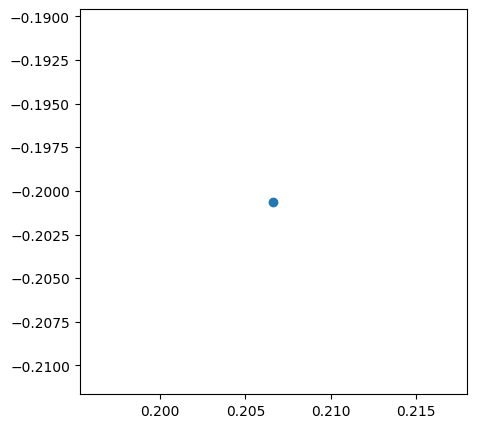

In [ ]:
#Let's feed a single word into the model we setup and output a fingerprint for that word
w = 'thinking'  #the input

plt.figure(figsize=(5,5))

#the for loop below goes through the process of generating a unique fingerprint for a given word
for word in all_words:
  if w == word:
    coordinates = word_embeddings[w]
    plt.scatter(coordinates[0], coordinates[1])

#Based on the results, there is only one coordinate pair for "thinking", which is why the fingerprint looks that way


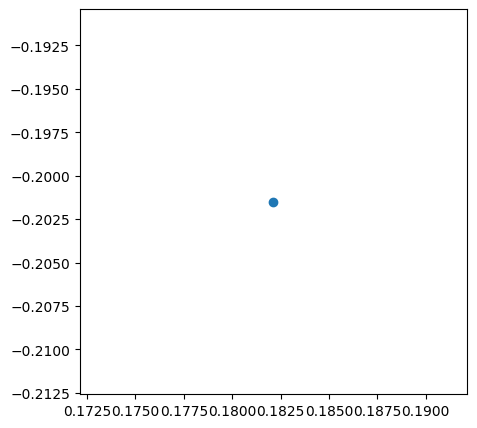

In [ ]:
#Let's feed another single word into this model
w = 'school'  #the input

plt.figure(figsize=(5,5))

#the for loop below goes through the process of generating a unique fingerprint for a given word
for word in all_words:
  if w == word:
    coordinates = word_embeddings[w]
    plt.scatter(coordinates[0], coordinates[1])

#Based on the results, there is only one coordinate pair for "school", which is why the fingerprint looks that way

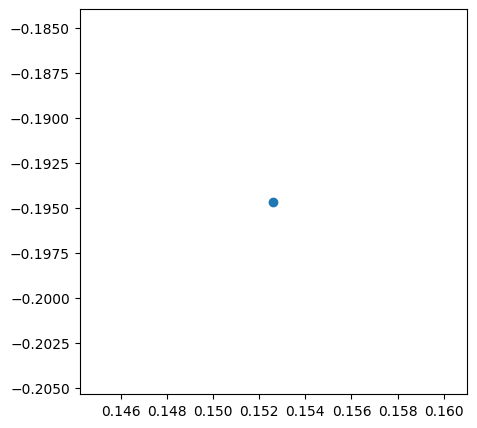

In [ ]:
#Let's feed another single word into this model
w = 'education'  #the input

plt.figure(figsize=(5,5))

#the for loop below goes through the process of generating a unique fingerprint for a given word
for word in all_words:
  if w == word:
    coordinates = word_embeddings[w]
    plt.scatter(coordinates[0], coordinates[1])

#Based on the results, there is only one coordinate pair for "education", which is why the fingerprint looks that way

# Feeding More Than One Word Into The Model:

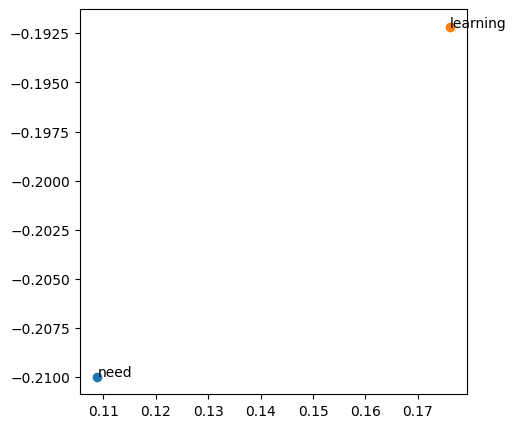

In [ ]:
#Now, let's feed a sentence into the model
sentence = 'I need to think a lot when learning something new.'  #the input
sentence_list = sentence.split()  #puts each word into a list

plt.figure(figsize=(5,5))

for w in sentence_list:
  for word in all_words:
    if w == word:
      coordinates = word_embeddings[w]
      plt.scatter(coordinates[0], coordinates[1])
      plt.annotate(word, (coordinates[0], coordinates[1]))


#The model only displays two coordinates. This is probably an indication that the model only recognizes the words "learning" and "need"
#but not any other words.
#In order to generate a more detailed fingerprint, the model needs to probably be setup to have more words entered into it initially




### Exercises:

1) Based on the results, the fingerprint doesn't fully capture our sentence, because there are words that weren't fed into the model. How would I go about graphing coordinates of those new words the model doesn't know?

2) Generally speaking, how could I go about having this model identify the appropriate contexts for new words without having to simply feed more data into the model?